In [12]:
import geopandas as gpd 
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
from datetime import datetime
import math
import numpy as np

In [7]:
os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

In [8]:
shpfl = gpd.read_file("/home/yhuang21/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp")

# Code to filter to shapefile

# extract a dataframe of the coordinates from the shapefile
coords = shpfl.get_coordinates()
# find the maximum and minimum lat/longs, corresponding to the red points on the figure above
lon_min = min(coords['x'])
lon_max = max(coords['x'])
lat_min = min(coords['y'])
lat_max = max(coords['y'])

In [18]:
xr.open_dataset('/home/yhuang21/remoteData/GLDAS/NOAH_monthly_L4/GLDAS_NOAH025_M.A200001.021.nc4')

<xarray.Dataset>
Dimensions:                (time: 1, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time                   (time) datetime64[ns] 2000-01-01
  * lon                    (lon) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * lat                    (lat) float32 -59.88 -59.62 -59.38 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] ...
    Swnet_tavg             (time, lat, lon) float32 ...
    Lwnet_tavg             (time, lat, lon) float32 ...
    Qle_tavg               (time, lat, lon) float32 ...
    Qh_tavg                (time, lat, lon) float32 ...
    Qg_tavg                (time, lat, lon) float32 ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 ...
    Tair_f_inst            (time, lat, lon) float32 ...
    Qair_f_inst            (time, lat, lon) float32 ...
    Psurf_f_inst           (time, lat, lon) float32 ...
    SWdown_f_tavg          (time, lat, lon) float32 ...
    LWdown_f_tavg          (time, lat, lon) float32 ...
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-17T14:58:21.836
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [9]:
### import GLDAS data, filter to CRB, combine into one dataframe 
gl_path = "/home/yhuang21/remoteData/GLDAS/NOAH_monthly_L4/"

gl_df = pd.DataFrame()

#Iterating through files in path
for filename in os.listdir(gl_path):
    
    if filename.endswith(".nc4"):
        #Reading in data as xarray then converting to DataFrame
        xd = xr.open_dataset(gl_path+str(filename))
        xd_df = xd.to_dataframe()

        xd_df.reset_index(inplace=True)

        xd_df = xd_df[(xd_df.lon> lon_min) & (xd_df.lon < lon_max)]
        xd_df = xd_df[(xd_df.lat> lat_min) & (xd_df.lat < lat_max)]

        #Extracting only needed columns 
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", "RootMoist_inst"]]
        df_slice = df_slice.drop_duplicates()

        gl_df = pd.concat([gl_df, df_slice], axis=0)

In [16]:
gl_df

,time,lon,lat,SWE_inst,RootMoist_inst
146764,2017-10-01,-118.875,31.125,NaN,NaN
146765,2017-10-01,-118.875,31.375,NaN,NaN
146766,2017-10-01,-118.875,31.625,NaN,NaN
146767,2017-10-01,-118.875,31.875,NaN,NaN
146768,2017-10-01,-118.875,32.125,NaN,NaN
...,...,...,...,...,...
187009,2000-01-01,-102.125,42.375,0.668583,72.323608
187010,2000-01-01,-102.125,42.625,0.551255,71.502670
187011,2000-01-01,-102.125,42.875,0.551538,64.827583
187012,2000-01-01,-102.125,43.125,0.763360,169.107285


In [17]:
gl_df.dtypes

time              datetime64[ns]
lon                      float32
lat                      float32
SWE_inst                 float32
RootMoist_inst           float32
dtype: object

In [20]:
# Filter the dataframe to include only the required dates
mask = (gl_df['time'] >= '2004-01-01') & (gl_df['time'] <= '2009-12-31')
filtered_df = gl_df.loc[mask]

# Group by lat and lon and calculate average storage for the specified date range
average_df = filtered_df.groupby(['lat','lon']).agg({'SWE_inst':'mean', 'RootMoist_inst':'mean'}).reset_index()
average_df = average_df.rename(columns={'SWE_inst':'SWE_mean', 'RootMoist_inst':'RootMoist_mean'})

gl_df = gl_df.merge(average_df, on=['lat','lon'], how='left')
gl_df['SWE_anomaly'] = gl_df['SWE_inst'] - gl_df['SWE_mean']
gl_df['RM_anomaly'] = gl_df['RootMoist_inst'] - gl_df['RootMoist_mean']

In [21]:
gl_df

,time,lon,lat,SWE_inst,RootMoist_inst,SWE_mean,RootMoist_mean,SWE_anomaly,RM_anomaly
0,2017-10-01,-118.875,31.125,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-10-01,-118.875,31.375,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-10-01,-118.875,31.625,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-10-01,-118.875,31.875,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-10-01,-118.875,32.125,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
948595,2000-01-01,-102.125,42.375,0.668583,72.323608,0.759089,92.380280,-0.090506,-20.056671
948596,2000-01-01,-102.125,42.625,0.551255,71.502670,0.702454,88.535011,-0.151199,-17.032341
948597,2000-01-01,-102.125,42.875,0.551538,64.827583,0.734256,82.129982,-0.182718,-17.302399
948598,2000-01-01,-102.125,43.125,0.763360,169.107285,0.833941,179.812805,-0.070581,-10.705521


In [25]:
# 6,371,000 is earth's radius in meter
gl_df['surface_area_m2'] = 6371000 * np.radians(.25) * 6371000 * np.radians(.25)*np.cos(np.radians(gl_df['lat']))

In [27]:
# converting kg to cm3
gl_df['RM_anom_area'] = gl_df['RM_anomaly'] * gl_df['surface_area_m2'] * 1000
gl_df['SWE_anom_area'] = gl_df['SWE_anomaly'] * gl_df['surface_area_m2'] * 1000

In [36]:
gl_df

,time,lon,lat,SWE_inst,RootMoist_inst,SWE_mean,RootMoist_mean,SWE_anomaly,RM_anomaly,surface_area_m2,RM_anom_area,SWE_anom_area
0,2017-10-01,-118.875,31.125,NaN,NaN,NaN,NaN,NaN,NaN,661522816.0,NaN,NaN
1,2017-10-01,-118.875,31.375,NaN,NaN,NaN,NaN,NaN,NaN,659773632.0,NaN,NaN
2,2017-10-01,-118.875,31.625,NaN,NaN,NaN,NaN,NaN,NaN,658011840.0,NaN,NaN
3,2017-10-01,-118.875,31.875,NaN,NaN,NaN,NaN,NaN,NaN,656237504.0,NaN,NaN
4,2017-10-01,-118.875,32.125,NaN,NaN,NaN,NaN,NaN,NaN,654450688.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
948595,2000-01-01,-102.125,42.375,0.668583,72.323608,0.759089,92.380280,-0.090506,-20.056671,570883072.0,-1.145001e+13,-5.166822e+10
948596,2000-01-01,-102.125,42.625,0.551255,71.502670,0.702454,88.535011,-0.151199,-17.032341,568605056.0,-9.684675e+12,-8.597257e+10
948597,2000-01-01,-102.125,42.875,0.551538,64.827583,0.734256,82.129982,-0.182718,-17.302399,566316288.0,-9.798630e+12,-1.034759e+11
948598,2000-01-01,-102.125,43.125,0.763360,169.107285,0.833941,179.812805,-0.070581,-10.705521,564016704.0,-6.038092e+12,-3.980867e+10


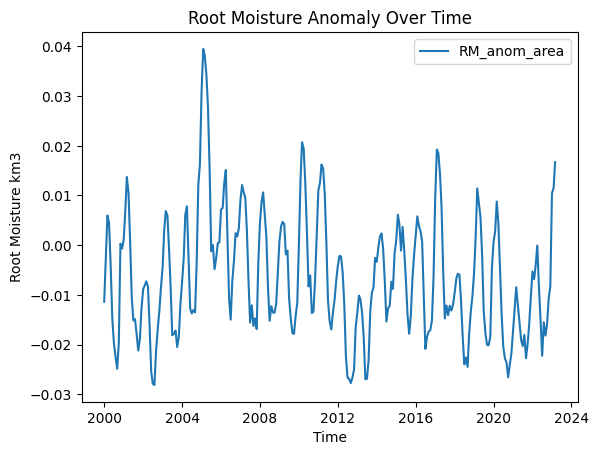

In [37]:
import matplotlib.pyplot as plt

# Convert 'date time' to datetime
plot_df = gl_df.copy()

# Convert from cm3 to km3
plot_df['RM_anom_area'] = plot_df['RM_anom_area'] / 1000000000000000
avg_rm_df = plot_df.groupby('time')['RM_anom_area'].mean().reset_index()


# Add label for the line in the plot function
plt.plot('time', 'RM_anom_area', data=avg_rm_df)
plt.title('Root Moisture Anomaly Over Time')
plt.xlabel('Time')
plt.ylabel('Root Moisture Anomaly km3')

# Add a legend
plt.legend()

plt.show()

In [42]:
plot_df

,time,lon,lat,SWE_inst,RootMoist_inst,SWE_mean,RootMoist_mean,SWE_anomaly,RM_anomaly,surface_area_m2,RM_anom_area,SWE_anom_area
0,2017-10-01,-118.875,31.125,NaN,NaN,NaN,NaN,NaN,NaN,661522816.0,NaN,NaN
1,2017-10-01,-118.875,31.375,NaN,NaN,NaN,NaN,NaN,NaN,659773632.0,NaN,NaN
2,2017-10-01,-118.875,31.625,NaN,NaN,NaN,NaN,NaN,NaN,658011840.0,NaN,NaN
3,2017-10-01,-118.875,31.875,NaN,NaN,NaN,NaN,NaN,NaN,656237504.0,NaN,NaN
4,2017-10-01,-118.875,32.125,NaN,NaN,NaN,NaN,NaN,NaN,654450688.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
948595,2000-01-01,-102.125,42.375,0.668583,72.323608,0.759089,92.380280,-0.090506,-20.056671,570883072.0,-0.011450,-5.166822e+10
948596,2000-01-01,-102.125,42.625,0.551255,71.502670,0.702454,88.535011,-0.151199,-17.032341,568605056.0,-0.009685,-8.597257e+10
948597,2000-01-01,-102.125,42.875,0.551538,64.827583,0.734256,82.129982,-0.182718,-17.302399,566316288.0,-0.009799,-1.034759e+11
948598,2000-01-01,-102.125,43.125,0.763360,169.107285,0.833941,179.812805,-0.070581,-10.705521,564016704.0,-0.006038,-3.980867e+10


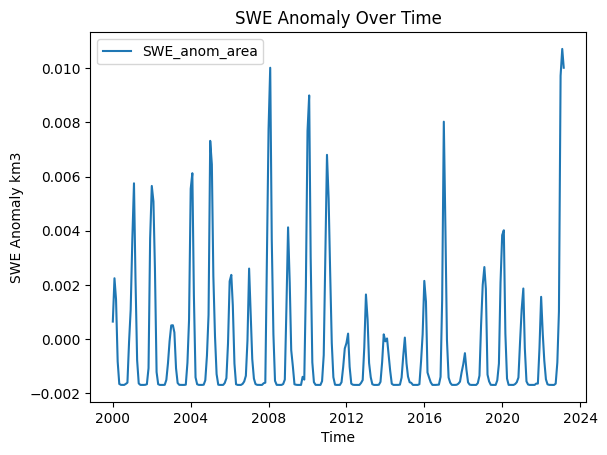

In [43]:
# Convert from cm3 to km3
plot_df['SWE_anom_area'] = plot_df['SWE_anom_area'] / 1000000000000000
avg_swe_df = plot_df.groupby('time')['SWE_anom_area'].mean().reset_index()


# Add label for the line in the plot function
plt.plot('time', 'SWE_anom_area', data=avg_swe_df)
plt.title('SWE Anomaly Over Time')
plt.xlabel('Time')
plt.ylabel('SWE Anomaly km3')

# Add a legend
plt.legend()

plt.show()

In [44]:
plot_df

,time,lon,lat,SWE_inst,RootMoist_inst,SWE_mean,RootMoist_mean,SWE_anomaly,RM_anomaly,surface_area_m2,RM_anom_area,SWE_anom_area
0,2017-10-01,-118.875,31.125,NaN,NaN,NaN,NaN,NaN,NaN,661522816.0,NaN,NaN
1,2017-10-01,-118.875,31.375,NaN,NaN,NaN,NaN,NaN,NaN,659773632.0,NaN,NaN
2,2017-10-01,-118.875,31.625,NaN,NaN,NaN,NaN,NaN,NaN,658011840.0,NaN,NaN
3,2017-10-01,-118.875,31.875,NaN,NaN,NaN,NaN,NaN,NaN,656237504.0,NaN,NaN
4,2017-10-01,-118.875,32.125,NaN,NaN,NaN,NaN,NaN,NaN,654450688.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
948595,2000-01-01,-102.125,42.375,0.668583,72.323608,0.759089,92.380280,-0.090506,-20.056671,570883072.0,-0.011450,-0.000052
948596,2000-01-01,-102.125,42.625,0.551255,71.502670,0.702454,88.535011,-0.151199,-17.032341,568605056.0,-0.009685,-0.000086
948597,2000-01-01,-102.125,42.875,0.551538,64.827583,0.734256,82.129982,-0.182718,-17.302399,566316288.0,-0.009799,-0.000103
948598,2000-01-01,-102.125,43.125,0.763360,169.107285,0.833941,179.812805,-0.070581,-10.705521,564016704.0,-0.006038,-0.000040
